## Step 1: Install necessary packages

In [1]:
# Install necessary packages
!pip install mne
!pip install gluonts
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.6 MB/s eta 0:00:00


In [2]:
ls

sample_data/


In [3]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 86 (delta 23), reused 11 (delta 11), pack-reused 55
Receiving objects: 100% (86/86), 176.84 KiB | 2.42 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [4]:
cd lag-llama

/content/lag-llama


In [5]:
!pip install -r requirements.txt # this could take some time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.1
    Uninstalling pydantic-

### download the pretrained model weights

In [6]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmp8pn616zk
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 149MB/s]
/content/lag-llama/lag-llama.ckpt


### Import

In [7]:
import mne
import pandas as pd
import numpy as np
import torch
from itertools import islice
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset
from lag_llama.gluon.estimator import LagLlamaEstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Step 2: Prepare the EEG data

In [8]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)
print(raw)
print(raw.info)

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 641GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 59s (1576.2 MB)
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.3 MB, data not loaded>
<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz


### Get the data for the time series


In [9]:
data, times = raw.get_data(return_times=True)
print(type(data))

<class 'numpy.ndarray'>


### Create dataset

In [10]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

def create_dataset(data):

  time_index = pd.date_range(start='2023-01-01 00:00:00', periods=41700, freq='0.00665984S')
  df = pd.DataFrame(data.T, index=time_index, columns=["target"])

  # Set numerical columns as float32
  for col in df.columns:
      # Check if column is not of string type
      if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
          df[col] = df[col].astype('float32')

  dataset = PandasDataset(df, target="target")
  return dataset

## Step 3: Lag-Llama model

### Get predictions

In [17]:
def get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0')) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]


    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with


        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)


    return forecasts, tss

### Set the parameters for forecasting

In [129]:
PREDICTION_LENGTH = 24  # Define your prediction length
NUM_SAMPLES = 10 # number of samples sampled from the probability distribution for each timestep
NUM_CHANNELS = 12 # number of channles that we want to forecast

### Forecast and plot first 12 (NUM_CHANNELS) EEG channels
Green color -> forecasts \
Blue color -> target

In [130]:
forecasts_arr, tss_arr = [], []

for i in range(NUM_CHANNELS):
  # create dataset for a channel
  dataset = create_dataset(data[i])
  # get forecasts and tss for a channel
  forecasts, tss = get_lag_llama_predictions(dataset, PREDICTION_LENGTH, NUM_SAMPLES)
  forecasts_arr.append(forecasts)
  tss_arr.append(tss)

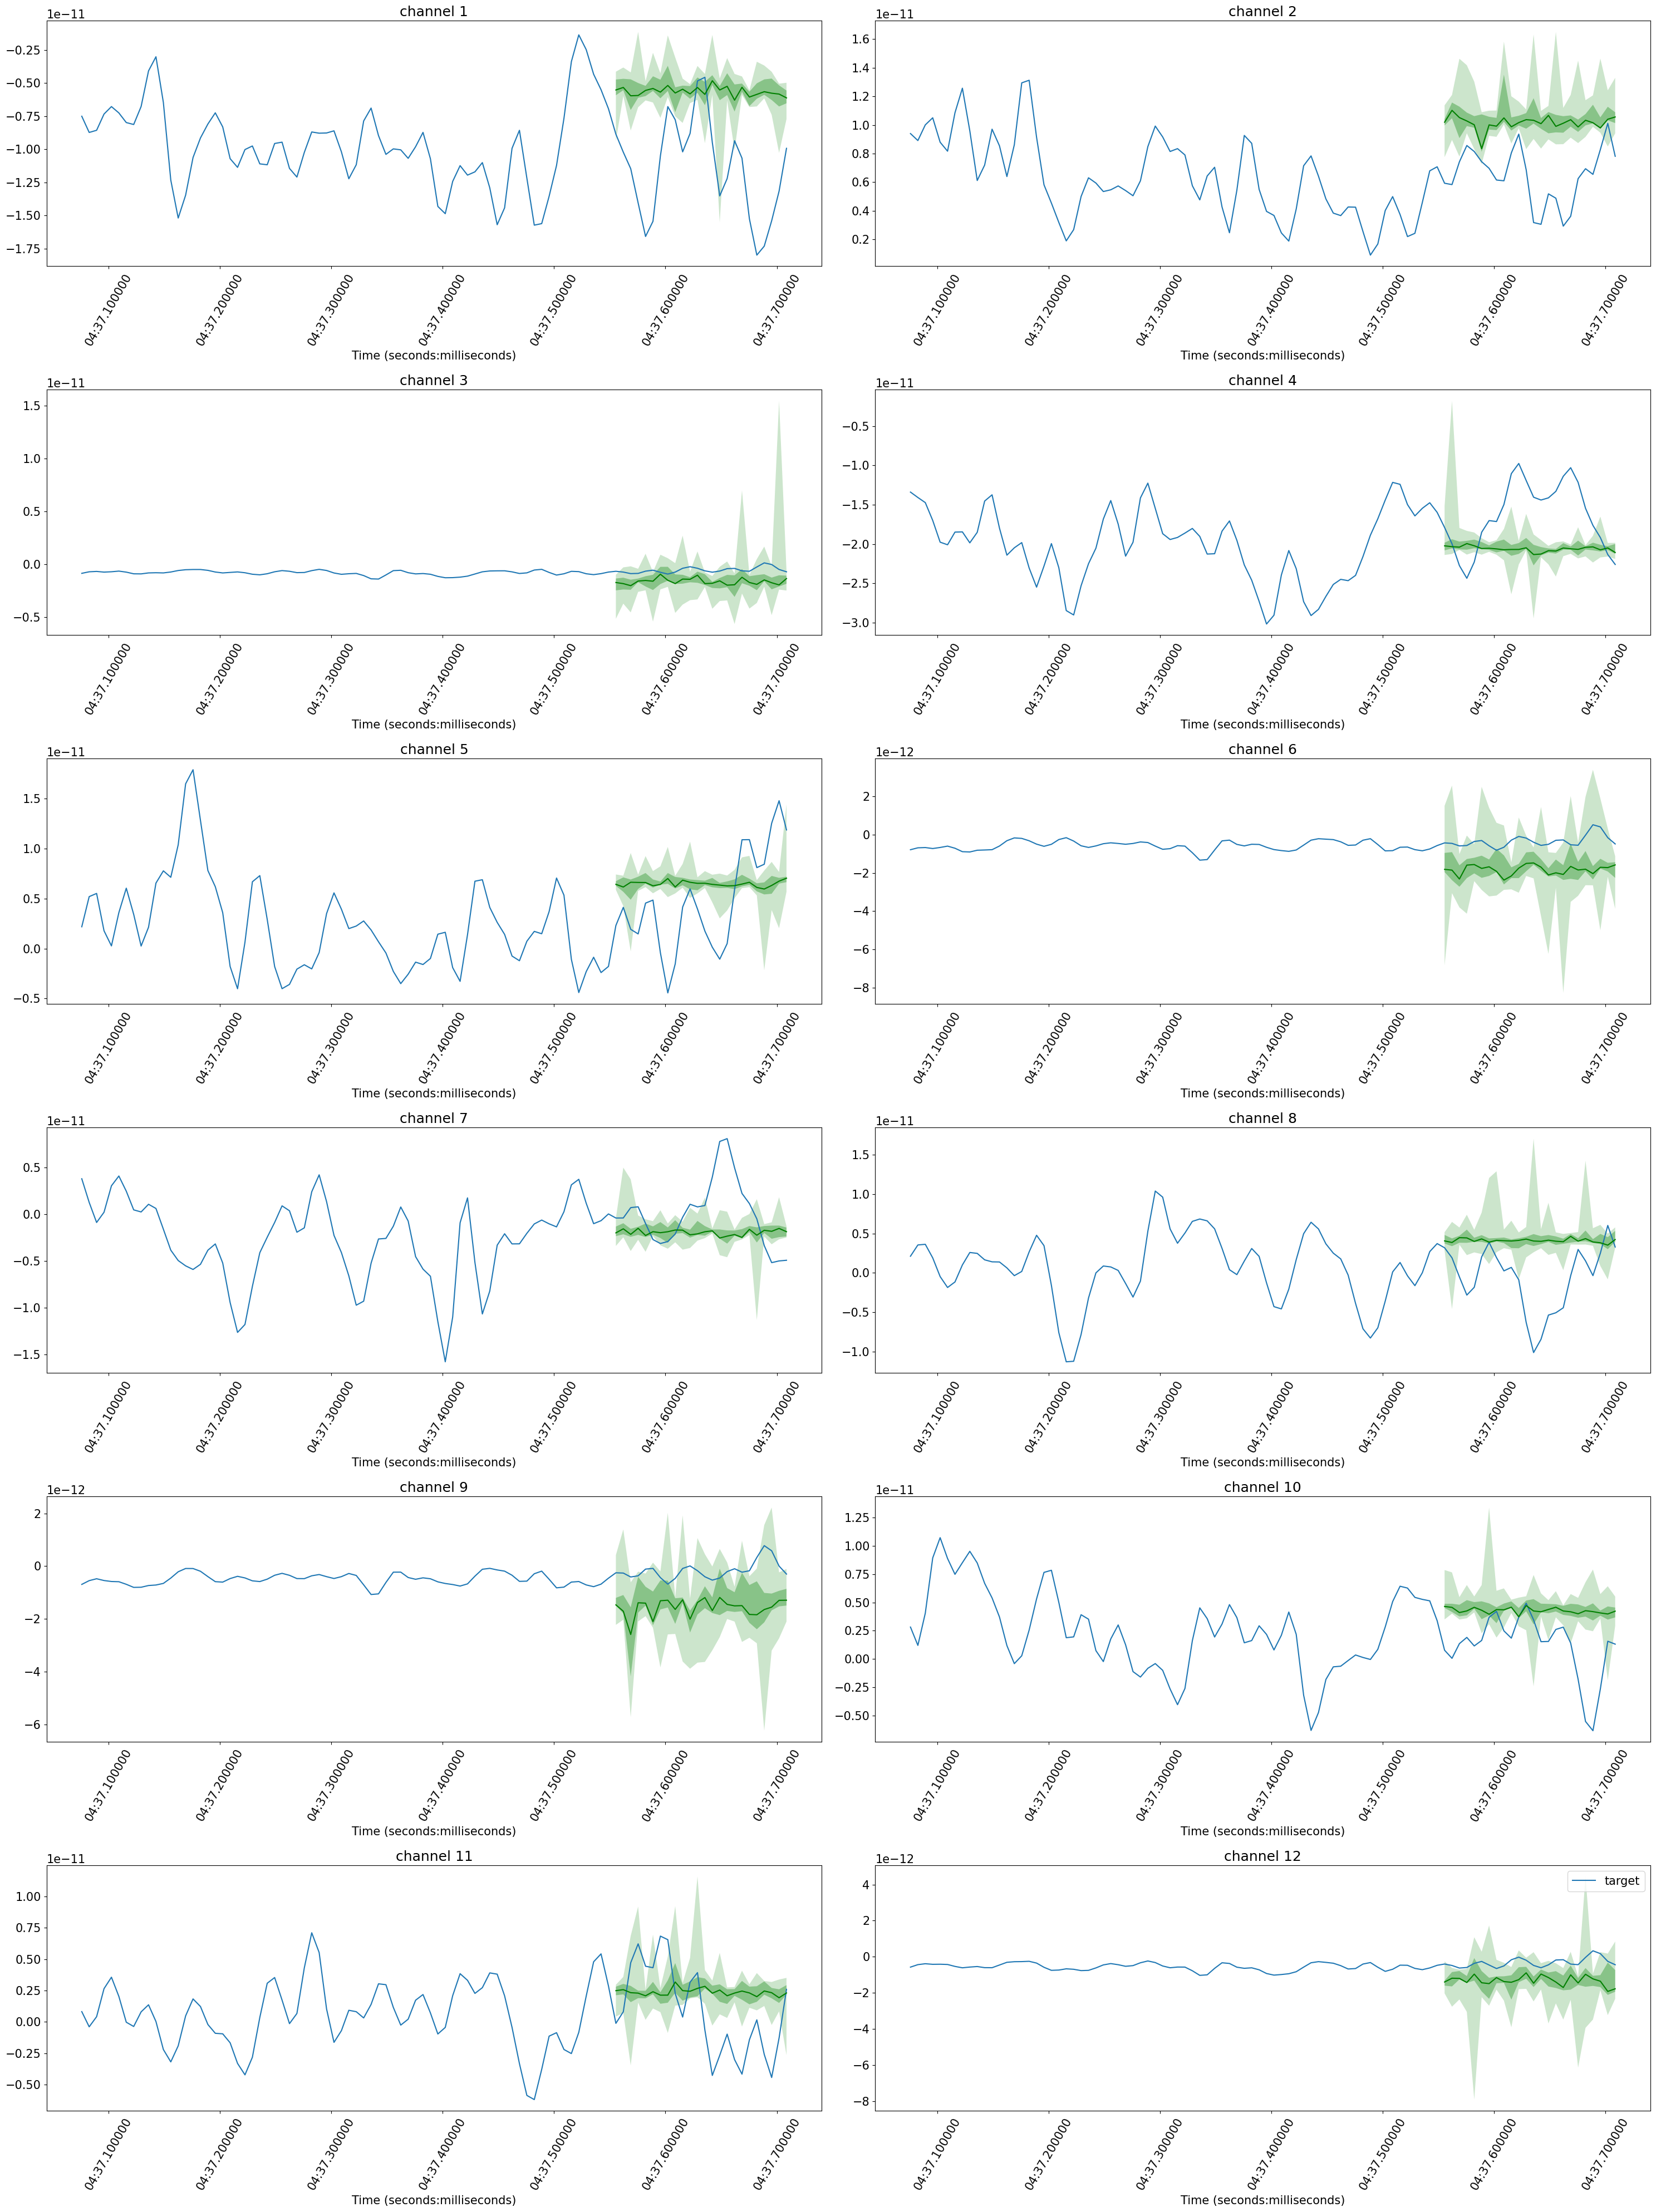

In [128]:
plt.figure(figsize=(30, 40))
plt.rcParams.update({'font.size': 15})

# Iterate through the first  series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_arr, tss_arr)), NUM_CHANNELS):
  forecast = forecast[0]
  ts = ts[0]
  ax = plt.subplot(6, 2, idx+1)

  plt.plot(ts[-4 * PREDICTION_LENGTH:].to_timestamp(), label="target", )
  forecast.plot( color='g')
  plt.xticks(rotation=60)
  ax.set_title(f'channel {idx + 1}')
  plt.xlabel('Time (seconds:milliseconds)')

plt.gcf().tight_layout()
plt.legend()
plt.show()